In [1]:
import pandas as pd 
import numpy as np 
import edhc as erk 

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
def discount(t, r):
    """
    compute the price of pure discount bond that pays of a dollar at time t, given interest rate r
    """
    return (1+r)**(-t)
    

In [6]:
def pv(l, r):
    """Compute the percent of value of a sequence of libilities l is indexed by time, and the value are
       amount of each liability returns the percent value of the sequence"""
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum() 

In [7]:
def funding_ratio(assets, liabilities, r):
    """Compute the funding ratio of some assets given liabilities and interest rate"""
    return assets/pv(liabilities, r)


In [8]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline 

In [9]:
def show_funding_ratio(assets, r):
    """plot the funding ratio"""
    fr = funding_ratio(assets, liabilities="liabilities",r)
    print(f"{fr*100:0.2f}")

controls = widgets.interactive(show_funding_ratio,
                              assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                              r=(0, .20, .01)
                              )
display()

SyntaxError: positional argument follows keyword argument (<ipython-input-9-2e43207b1056>, line 3)

In [3]:
def inst_to_ann(r):
    """
    Convert short ratet to annulized rate
    """
    return np.expm1(r)


In [4]:
def ann_to_inst(r):
    """
    Convert annulized rate to short rate
    """
    return np.log1p(r)

In [13]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implemnting the CIR model interst rates 
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years * steps_per_year)
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))    

In [7]:
%matplotlib inline

<AxesSubplot:>

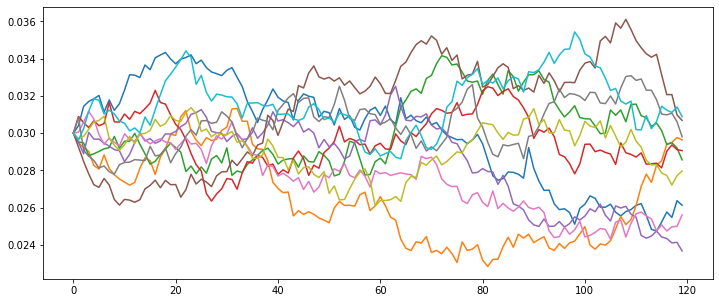

In [16]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [17]:
import ipywidgets as widgets
from IPython.display import display

In [24]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a , b=b, sigma=sigma, n_scenarios=n_scenarios).plot(figsize=(12,5), legend=False)

In [25]:
controls= widgets.interactive(show_cir,
                             r_0= (0, .15,.01),
                             a= (0,1,.1),
                             b= (0, 0.15, .01),
                             sigma=(0, 0.1, .01),
                             n_scenarios=(1,100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

# GHP Construction with Duration Matching 

In [7]:
import numpy as np 
import pandas as pd 
import edhec_risk_kit as erk 
import edhc as fi
%matplotlib inline

In [11]:
fi.bond_cash_flows(3,100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [14]:
fi.bond_price(20, 1000, 0.05, 2, .04)

0    1136.777396
dtype: float64

In [15]:
rates = np.linspace(0.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [16]:
prices = [fi.bond_price(10, 1000, .05, 2, rate) for rate in rates]

In [18]:
print(prices)

[0    1379.748383
dtype: float64, 0    1326.762928
dtype: float64, 0    1276.163298
dtype: float64, 0    1227.833538
dtype: float64, 0    1181.663651
dtype: float64, 0    1137.549279
dtype: float64, 0    1095.3914
dtype: float64, 0    1055.096038
dtype: float64, 0    1016.573997
dtype: float64, 0    979.740605
dtype: float64, 0    944.515473
dtype: float64, 0    910.822268
dtype: float64, 0    878.588497
dtype: float64, 0    847.745306
dtype: float64, 0    818.227287
dtype: float64, 0    789.972298
dtype: float64, 0    762.92129
dtype: float64, 0    737.018147
dtype: float64, 0    712.209532
dtype: float64, 0    688.444741
dtype: float64]


<AxesSubplot:title={'center':'Price of 10y bond with diff interest rate'}>

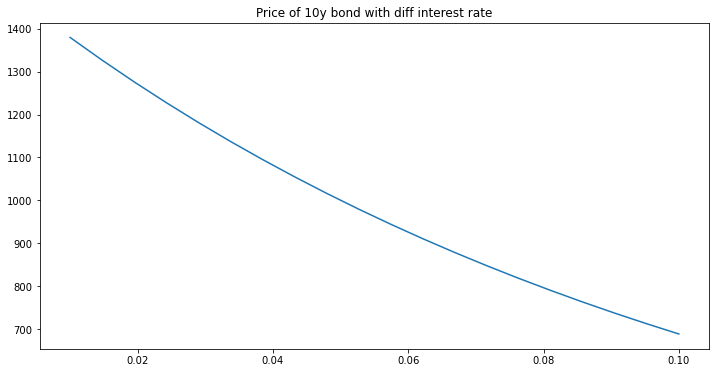

In [21]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10y bond with diff interest rate", legend=False, figsize=(12,6))

In [24]:
cf = fi.bond_cash_flows(3,1000, 0.06, 2)

In [25]:
discounts = erk.discount(cf.index, .06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [29]:
dcf = discounts*cf

In [30]:
dcf

,0,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
